Import all the dependencies

In [10]:
from IPython.display import display, Image
from urllib import request
from IPython.display import display, Image
from cv2 import VideoCapture
from cv2 import waitKey
import pandas as pd
import tensorflow  as tf
import tensorflow_hub as hub
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np
import imageio

In [3]:
UCF_Root = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101"
_VEDIO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
univearified_context = ssl._create_unverified_context()

def list_ucf_vedios():
    """Get the list of video from the ucf

    Returns:
        [list]: list of the video
    """
    global _VEDIO_LIST
    if not _VEDIO_LIST:
        index = request.urlopen(UCF_Root,context=univearified_context).read().decode("utf-8")
        vedio = re.findall("(v_[\w_]+\.avi)",index)
        _VEDIO_LIST = sorted(set(vedio))
    return list(_VEDIO_LIST)

def fetch_ucf_vedio(vedio):
    """
    *Get the video from the list of vedio
    *Request to the website of vidio
    Args:
        vedio ([sTr]): Name of the vedio

    Returns:
        [str]: return the path of the vedio in local
    """
    cache_path = os.path.join(_CACHE_DIR,vedio)
    if not os.path.exists(cache_path):
        urlpath = UCF_Root+"/"+vedio
        print(f"Fetching %s=>f{(urlpath,cache_path)}")
        data = request.urlopen(urlpath,context=univearified_context).read()
        open(cache_path,"wb").write(data)
    return cache_path

def crop_center_square(frame):
    """Crop the main event of the vedio

    Args:
        frame ([2d Array]): Frame of the vedio(Vedio is collection the frame)

    Returns:
        [2d Array]: crop frame
    """
    y,x = frame.shape[0:2]
    min_dim = min(y,x)
    start_x = (x//2)-(min_dim//2)
    start_y = (y//2)-(min_dim//2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_vedio(path = 0,max_frames = 0,resize=(224,224)):
    """load the given vedio

    Args:
        path (int, 0): path of the vedio. Defaults to 0.
        max_frames (int, optional): when no frames are remaining they will stop the looping Defaults to 0.
        resize (tuple, optional): Resize the vedio frame to get the one size vedio frame. Defaults to (224,224).

    Returns:
        [np.array]: Array of the frames
    """
    cap = VideoCapture(path)
    frames = []
    try:
        while True:
            ret,frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame,resize)
            frame = frame[:,:,[2,1,0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)/255.0

def to_gif(images):
    """Convert the vedio frame to gif

    Args:
        images (np.array): coolection of the frames of the vedio
    """
    global vedio_data
    path = f"gif/{vedio_data.split(".")[0]}.gif"
    converted_images = np.clip(images*255,0,255).astype(np.uint8)
    image = imageio.mimsave(path,converted_images,fps = 25)
    display(Image(filename=os.getcwd()+"/"+path))

<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Naman Agrawal\AppData\Local\Temp\ipykernel_17584\3033937337.py:15: SyntaxWarning: invalid escape sequence '\w'
  vedio = re.findall("(v_[\w_]+\.avi)",index)


In [4]:

"""Get the lables of the motion
"""
KINETICS_URL = r"C:\Users\Naman Agrawal\OneDrive\Documents\Vedio Classifier\label_map.txt" 
with open(KINETICS_URL) as obj:
    lables = [line for line in obj.readlines()]
print(f"Found  Total : {len(lables)} ")
    

Found  Total : 400 


In [5]:
ucf_vedio = list_ucf_vedios()
categories = {}
for vedio in ucf_vedio:
    category = vedio[2:12]
    if category  not in categories:
        categories[category] = []
    categories[category].append(vedio)
# print(f"found in total {len(ucf_vedio)} in overall {len(categories)} categories")

data_set_name = [] 
for cat, seq in categories.items():
    data_set_name.append(seq[0])

In [17]:
vedio_data = random.choice(data_set_name)
vediopath = fetch_ucf_vedio(vedio_data)
smaple = load_vedio(vediopath)
sample_vedio = load_vedio(vediopath)[:100]

Fetching %s=>f('https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Rowing_g13_c01.avi', 'C:\\Users\\NAMANA~1\\AppData\\Local\\Temp\\tmpw5gwt0qs\\v_Rowing_g13_c01.avi')


In [7]:
"""model architecture for video classification tasks. The Kinetics-400 dataset is a large-scale video dataset used for action recognition. This model is pretrained on this dataset, allowing you to use it for various video analysis tasks without needing to train it from scratch.
"Inflated 3D Convne"
"""
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures["default"]

tf.constant(sample_video, dtype=tf.float32): This creates a TensorFlow constant tensor from the sample_video array. The data type is specified as tf.float32, indicating that the elements of the tensor are 32-bit floating-point numbers.
[tf.newaxis, ...]: This adds a new axis at the beginning of the tensor, effectively converting the 3D tensor (representing a single video) into a 4D tensor. This is often necessary to match the input shape expected by the model.
In summary, tensors in TensorFlow are data structures that represent multi-dimensional arrays. They are fundamental building blocks used to represent data and perform computations in TensorFlow. In the context of neural networks, tensors are used to represent inputs, weights, biases, activations, and outputs throughout the computational graph.






In [14]:
def predict(sample_vedio):
    """pridiict the motion from the video

    Args:
        sample_vedio (Array): Vedio

    Returns:
        [dict]: predict data
    """
    model_input = tf.constant(sample_vedio,dtype = tf.float32)[tf.newaxis,...]

    logits = i3d(model_input)["default"][0]
    probibilties = tf.nn.softmax(logits)
    final_data = {}
    print("Top 5 action")
    for i in np.argsort(probibilties)[::-1][:5]:
        final_data[lables[i]]= probibilties[i].numpy()*100
    return final_data
        
def show_data(pridict_data):
    """Show the data

    Args:
        pridict_data (Dataframe): pridict data
    """
    column = [col.replace("\n","").title() for col in pridict_data.keys()]
    df = pd.DataFrame(pridict_data.values(),column)
    print(df.to_string(header=False))
    
    

Top 5 action


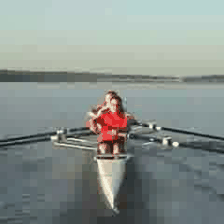

Water Skiing      54.439688
Hula Hooping      22.146814
Sailing            9.156444
Playing Trombone   6.568487
Jetskiing          2.762535


In [18]:
pridict_data = predict(sample_vedio)
to_gif(sample_vedio)
show_data(pridict_data)
